# Building a technical documentation agent with MongoDB, Gemini, and LangGraph

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mongodb-developer/GenAI-Showcase/blob/main/notebooks/agents/docs_agent_mongodb_langgraph.ipynb)

#### **NOTE**: The 📚 emoji indicates reference documentation.

# Step 1: Install required libraries

* **pymongo**: Python driver for MongoDB
* **langchain**: Python library for LangChain, an LLM app orchestration framework
* **langchain-google-genai**: Python library to use Google's GenAI models in LangChain
* **langgraph**: Python library for LangChain's agent orchestration framework, LangGraph
* **langgraph-checkpoint-mongodb**: Python library to add MongoDB as a checkpointer in LangGraph
* **sentence_transformers**: Python library to use open-source ML models from Hugging Face

In [2]:
! pip install -qU pymongo langchain langchain-google-genai langgraph langgraph-checkpoint-mongodb sentence_transformers

# Step 2: Setup prerequisites

* Register for a [free MongoDB Atlas account](https://www.mongodb.com/cloud/atlas/register)
* [Create a new database cluster](https://www.mongodb.com/docs/guides/atlas/cluster/)
* [Obtain the connection string](https://www.mongodb.com/docs/guides/atlas/connection-string/) for your database cluster

In [3]:
import getpass

from pymongo import MongoClient

In [4]:
# Paste your MongoDB connection string. Be sure to replace the password placeholder with your actual password.
MONGODB_URI = getpass.getpass("Enter your MongoDB connection string:")
# Initialize a MongoDB Python client
mongodb_client = MongoClient(MONGODB_URI, appname="devrel.workshop.agents")
# Check the connection to the server
mongodb_client.admin.command("ping")

Enter your MongoDB connection string: ········


{'ok': 1.0,
 '$clusterTime': {'clusterTime': Timestamp(1744928532, 43),
  'signature': {'hash': b'\x7fN\x9d\xa9\x98\xbf\xcb\xf9\x9cy\xf0\xdd\xd3\x83\xa9v\x9e\xb8\x17)',
   'keyId': 7456513059255746561}},
 'operationTime': Timestamp(1744928532, 43)}

### **Do not change the values assigned to the variables below**

In [5]:
#  Database name
DB_NAME = "mongodb_genai_devday"
# Name of the collection with full documents- used for summarization
FULL_COLLECTION_NAME = "mongodb-docs"
# Name of the collection for vector search- used for Q&A
VS_COLLECTION_NAME = "mongodb-docs-embedded"
# Name of the vector search index
VS_INDEX_NAME = "vector_index"

📚 https://pymongo.readthedocs.io/en/stable/tutorial.html#getting-a-database

In [6]:
# Connect to the `DB_NAME` database.
db = mongodb_client[DB_NAME]

📚 https://pymongo.readthedocs.io/en/stable/tutorial.html#getting-a-collection

In [7]:
# Connect to the `VS_COLLECTION_NAME` collection.
vs_collection = db[VS_COLLECTION_NAME]

In [8]:
# Connect to the `FULL_COLLECTION_NAME` collection.
full_collection = db[FULL_COLLECTION_NAME]

In [9]:
# Endpoint for data import and to get the LangChain LLM object
SERVERLESS_URL = "https://vtqjvgchmwcjwsrela2oyhlegu0hwqnw.lambda-url.us-west-2.on.aws/"
# Set the LLM provider to `google` to use Gemini 1.5 Pro as the brain of the agent
LLM_PROVIDER = "google"

# Step 3: Import data into MongoDB

In [10]:
import requests

In [11]:
# Make a request to the serverless function to import data into MongoDB
response = requests.post(
    url=SERVERLESS_URL, json={"task": "import_agents_data", "data": MONGODB_URI}
)
if response.status_code == 200:
    print(
        f"{vs_collection.count_documents({})} documents ingested into the {VS_COLLECTION_NAME} collection."
    )
    print(
        f"{full_collection.count_documents({})} documents ingested into the {FULL_COLLECTION_NAME} collection."
    )
else:
    raise Exception(response.json())

107 documents ingested into the mongodb-docs-embedded collection.
20 documents ingested into the mongodb-docs collection.


# Step 4: Create a vector search index

In [12]:
# Create vector index definition specifying:
# path: Path to the embeddings field
# numDimensions: Number of embedding dimensions- depends on the embedding model used
# similarity: Similarity metric. One of cosine, euclidean, dotProduct.
model = {
    "name": VS_INDEX_NAME,
    "type": "vectorSearch",
    "definition": {
        "fields": [
            {
                "type": "vector",
                "path": "embedding",
                "numDimensions": 384,
                "similarity": "cosine",
            }
        ]
    },
}

📚 https://pymongo.readthedocs.io/en/stable/api/pymongo/collection.html#pymongo.collection.Collection.create_search_index

In [13]:
# Create a vector search index with the above `model` for the `vs_collection` collection
vs_collection.create_search_index(model=model)

'vector_index'

# Step 5: Create agent tools

In [14]:
# You may see a warning upon running this cell. You can ignore it.
from typing import List

from langchain.agents import tool
from sentence_transformers import SentenceTransformer

### Vector Search

In [15]:
# Load the `gte-small` model using the Sentence Transformers library
embedding_model = SentenceTransformer("thenlper/gte-small")

📚 https://huggingface.co/thenlper/gte-small#usage (See "Use with sentence-transformers" under Usage)

In [16]:
# Define a function that takes a piece of text (`text`) as input, embeds it using the `embedding_model` instantiated above and returns the embedding as a list
# An array can be converted to a list using the `tolist()` method
def get_embedding(text: str) -> List[float]:
    """
    Generate the embedding for a piece of text.

    Args:
        text (str): Text to embed.

    Returns:
        List[float]: Embedding of the text as a list.
    """
    embedding = embedding_model.encode(text)
    return embedding.tolist()

📚 https://www.mongodb.com/docs/atlas/atlas-vector-search/vector-search-stage/#ann-examples (Refer to the "Basic Example")

In [17]:
# Define a tool to retrieve relevant documents for a user query using vector search
@tool
def get_information_for_question_answering(user_query: str) -> str:
    """
    Retrieve information using vector search to answer a user query.

    Args:
    user_query (str): The user's query string.

    Returns:
    str: The retrieved information formatted as a string.
    """

    # Generate embedding for the `user_query` using the `get_embedding` function defined above
    query_embedding = get_embedding(user_query)

    # Define an aggregation pipeline consisting of a $vectorSearch stage, followed by a $project stage
    # Set the number of candidates to 150 and only return the top 5 documents from the vector search
    # In the $project stage, exclude the `_id` field and include only the `body` field and `vectorSearchScore`
    pipeline = [
        {
            "$vectorSearch": {
                "index": VS_INDEX_NAME,
                "path": "embedding",
                "queryVector": query_embedding,
                "numCandidates": 150,
                "limit": 5,
            }
        },
        {
            "$project": {
                "_id": 0,
                "body": 1,
                "score": {"$meta": "vectorSearchScore"},
            }
        },
    ]

    # Execute the aggregation `pipeline` against the `vs_collection` collection and store the results in `results`
    results = vs_collection.aggregate(pipeline)
    # Concatenate the results into a string
    context = "\n\n".join([doc.get("body") for doc in results])
    return context

### Get page content

📚 https://www.mongodb.com/docs/manual/reference/method/db.collection.findOne/#return-all-but-the-excluded-fields

In [18]:
# Define a tool to retrieve the content of a documentation page for summarization
@tool
def get_page_content_for_summarization(user_query: str) -> str:
    """
    Retrieve page content based on provided title.

    Args:
    user_query (str): The user's query string i.e. title of the documentation page.

    Returns:
    str: The content of the page.
    """
    # Query the documents where the `title` field is equal to the `user_query`
    query = {"title": user_query}
    # Only return the `body` field from the retrieved documents.
    # Set fields to include to 1, those to exclude to 0. `_id` is included by default, so exclude that.
    projection = {"_id": 0, "body": 1}
    # Use the `query` and `projection` with the `find_one` method
    # to get the `body` of the document with `title` equal to the `user_query` from the `full_collection` collection
    document = full_collection.find_one(query, projection)
    if document:
        return document["body"]
    else:
        return "Document not found"

In [19]:
# Create the list of tools
tools = [
    get_information_for_question_answering,
    get_page_content_for_summarization,
]

### Test out the tools

In [20]:
# Test out the `get_information_for_question_answering` tool with the query "What are some best practices for data backups in MongoDB?"
# You should see a non-empty response
get_information_for_question_answering.invoke(
    "What are some best practices for data backups in MongoDB?"
)

"# Backup and Restore Sharded Clusters\n\nThe following tutorials describe backup and restoration for sharded clusters:\n\nTo use `mongodump` and `mongorestore` as a backup strategy for sharded clusters, you must stop the sharded cluster balancer and use the `fsync` command or the `db.fsyncLock()` method on `mongos` to block writes on the cluster during backups.\n\nSharded clusters can also use one of the following coordinated backup and restore processes, which maintain the atomicity guarantees of transactions across shards:\n\n- MongoDB Atlas\n\n- MongoDB Cloud Manager\n\n- MongoDB Ops Manager\n\nUse file system snapshots back up each component in the sharded cluster individually. The procedure involves stopping the cluster balancer. If your system configuration allows file system backups, this might be more efficient than using MongoDB tools.\n\nCreate backups using `mongodump` to back up each component in the cluster individually.\n\nCreate backups using `mongodump` to back up each

In [21]:
# Test out the `get_page_content_for_summarization` tool with page title "Create a MongoDB Deployment"
# You should see a non-empty response
get_page_content_for_summarization.invoke("Create a MongoDB Deployment")

"# Create a MongoDB Deployment\n\nYou can create a free tier MongoDB deployment on MongoDB Atlas to store and manage your data. MongoDB Atlas hosts and manages your MongoDB database in the cloud.\n\n## Create a Free MongoDB deployment on Atlas\n\nComplete the Get Started with Atlas guide to set up a new Atlas account and load sample data into a new free tier MongoDB deployment.\n\n## Save your Credentials\n\nAfter you create your database user, save that user's username and password to a safe location for use in an upcoming step.\n\nAfter you complete these steps, you have a new free tier MongoDB deployment on Atlas, database user credentials, and sample data loaded in your database.\n\nIf you run into issues on this step, ask for help in the MongoDB Community Forums or submit feedback by using the Rate this page tab on the right or bottom right side of this page.\n\n"

# Step 6: Define graph state

In [22]:
from typing import Annotated

from langgraph.graph.message import add_messages
from typing_extensions import TypedDict

In [23]:
# Define the graph state
# We are only tracking chat messages but you can track other attributes as well
class GraphState(TypedDict):
    messages: Annotated[list, add_messages]

# Step 7: Instantiate the LLM

In [24]:
from langchain_core.load import load
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

In [25]:
# Obtain the Langchain LLM object from our serverless endpoint
llm_dict = requests.post(
    url=SERVERLESS_URL, json={"task": "get_llm", "data": LLM_PROVIDER}
).json()
llm = load(llm_dict["llm"], secrets_map=llm_dict["secrets_map"])

/tmp/ipykernel_20033/2346806571.py:5: LangChainBetaWarning: The function `load` is in beta. It is actively being worked on, so the API may change.
  llm = load(llm_dict["llm"], secrets_map=llm_dict["secrets_map"])


In [26]:
# Create a Chain-of-Thought (CoT) prompt template for the agent.
# This includes a system prompt with a placeholder for tool names, and a placeholder for messages i.e. user queries and assistant responses
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "You are a helpful AI assistant."
            " You are provided with tools to answer questions and summarize technical documentation related to MongoDB."
            " Think step-by-step and use these tools to get the information required to answer the user query."
            " Do not re-run tools unless absolutely necessary."
            " If you are not able to get enough information using the tools, reply with I DON'T KNOW."
            " You have access to the following tools: {tool_names}."
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [27]:
# Fill in the prompt template with the tool names
prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))

📚 https://python.langchain.com/v0.1/docs/modules/model_io/chat/function_calling/#binding-tool-schemas

In [28]:
# Bind the `tools` to the `llm` instantiated above
bind_tools = llm.bind_tools(tools)

📚 https://python.langchain.com/v0.1/docs/expression_language/primitives/sequence/#the-pipe-operator

In [29]:
# Chain the `prompt` with the tool-bound llm using the `|` operator
llm_with_tools = prompt | bind_tools

In [30]:
# Test that the LLM is making the right tool calls
llm_with_tools.invoke(
    ["Give me a summary of the page titled Create a MongoDB Deployment."]
).tool_calls

[{'name': 'get_page_content_for_summarization',
  'args': {'user_query': 'Create a MongoDB Deployment'},
  'id': '0c0a9ca1-3071-4f04-8bc0-98b803b55baa',
  'type': 'tool_call'}]

In [31]:
# Test that the LLM is making the right tool calls
llm_with_tools.invoke(
    ["What are some best practices for data backups in MongoDB?"]
).tool_calls

[{'name': 'get_information_for_question_answering',
  'args': {'user_query': 'best practices for MongoDB backups'},
  'id': '567a5212-d74b-49f1-a4d4-82bba5bae457',
  'type': 'tool_call'}]

# Step 8: Define graph nodes

In [32]:
from pprint import pprint
from typing import Dict

from langchain_core.messages import ToolMessage

In [33]:
# Define the agent node
def agent(state: GraphState) -> Dict[str, List]:
    """
    Agent node

    Args:
        state (GraphState): Graph state

    Returns:
        Dict[str, List]: Updates to messages
    """
    # Get the messages from the graph `state`
    messages = state["messages"]
    # Invoke `llm_with_tools` with `messages` using the `invoke` method
    result = llm_with_tools.invoke(messages)
    # Write `result` to the `messages` attribute of the graph state
    return {"messages": [result]}

In [34]:
# Create a map of tool name to tool call
tools_by_name = {tool.name: tool for tool in tools}
pprint(tools_by_name)

{'get_information_for_question_answering': StructuredTool(name='get_information_for_question_answering', description="Retrieve information using vector search to answer a user query.\n\nArgs:\nuser_query (str): The user's query string.\n\nReturns:\nstr: The retrieved information formatted as a string.", args_schema=<class 'langchain_core.utils.pydantic.get_information_for_question_answering'>, func=<function get_information_for_question_answering at 0x7fbad49cb1c0>),
 'get_page_content_for_summarization': StructuredTool(name='get_page_content_for_summarization', description="Retrieve page content based on provided title.\n\nArgs:\nuser_query (str): The user's query string i.e. title of the documentation page.\n\nReturns:\nstr: The content of the page.", args_schema=<class 'langchain_core.utils.pydantic.get_page_content_for_summarization'>, func=<function get_page_content_for_summarization at 0x7fbad482cdc0>)}


In [35]:
# Define tool node
def tool_node(state: GraphState) -> Dict[str, List]:
    """
    Tool node

    Args:
        state (GraphState): Graph state

    Returns:
        Dict[str, List]: Updates to messages
    """
    result = []
    # Get the list of tool calls from messages
    tool_calls = state["messages"][-1].tool_calls
    # Iterate through `tool_calls`
    for tool_call in tool_calls:
        # Get the tool from `tools_by_name` using the `name` attribute of the `tool_call`
        tool = tools_by_name[tool_call["name"]]
        # Invoke the `tool` using the `args` attribute of the `tool_call`
        observation = tool.invoke(tool_call["args"])
        # Append the result of executing the tool to the `result` list as a ToolMessage
        # The `content` of the message is `observation` i.e. result of the tool call
        # The `tool_call_id` is obtained from the `tool_call`
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    # Write `result` to the `messages` attribute of the graph state
    return {"messages": result}

# Step 9: Define conditional edges

In [36]:
from langgraph.graph import END

In [37]:
# Define conditional routing function
def route_tools(state: GraphState):
    """
    Use in the conditional_edge to route to the tool node if the last message
    has tool calls. Otherwise, route to the end.
    """
    # Get messages from graph state
    messages = state.get("messages", [])
    if len(messages) > 0:
        # Get the last AI message from messages
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    # Check if the last message has tool calls
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        # If yes, return "tools"
        return "tools"
    # If no, return END
    return END

# Step 10: Build the graph

In [38]:
from IPython.display import Image, display
from langgraph.graph import START, StateGraph

In [39]:
# Instantiate the graph
graph = StateGraph(GraphState)

📚 https://blog.langchain.dev/langgraph/#nodes

In [40]:
# Add nodes to the `graph` using the `add_node` function
# Add a `agent` node. The `agent` node should run the `agent` function
graph.add_node("agent", agent)
# Add a `tools` node. The `tools` node should run the `tool_node` function
graph.add_node("tools", tool_node)

📚 https://langchain-ai.github.io/langgraph/concepts/low_level/#normal-edges

In [41]:
# Add fixed edges to the `graph` using the `add_edge` method
# Add an edge from the START node to the `agent` node
graph.add_edge(START, "agent")
# Add an edge from the `tools` node to the `agent` node
graph.add_edge("tools", "agent")

📚 https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges

In [43]:
# Use the `add_conditional_edges` method to add a conditional edge from the `agent` node to the `tools` node
# based on the output of the `route_tools` function
graph.add_conditional_edges(
    "agent",
    route_tools,
    {"tools": "tools", END: END},
)

In [44]:
# Compile the `graph`
app = graph.compile()

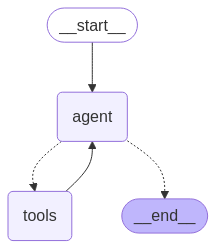

In [45]:
# Visualize the graph
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# Step 11: Execute the graph

In [46]:
# Stream outputs from the graph as they pass through its nodes
def execute_graph(user_input: str) -> None:
    """
    Stream outputs from the graph

    Args:
        user_input (str): User query string
    """
    # Add user input to the messages attribute of the graph state
    # The role of the message should be "user" and content should be `user_input`
    input = {"messages": [("user", user_input)]}
    # Pass input to the graph and stream the outputs
    for output in app.stream(input):
        for key, value in output.items():
            print(f"Node {key}:")
            print(value)
    print("---FINAL ANSWER---")
    print(value["messages"][-1].content)

In [47]:
# Test the graph execution to view end-to-end flow
execute_graph("What are some best practices for data backups in MongoDB?")

Node agent:
{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_information_for_question_answering', 'arguments': '{"user_query": "best practices for MongoDB backups"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-pro-002', 'safety_ratings': []}, id='run-30576fb3-c333-4e2a-a877-9120243af7bf-0', tool_calls=[{'name': 'get_information_for_question_answering', 'args': {'user_query': 'best practices for MongoDB backups'}, 'id': '5ed428f5-1ddc-460f-b649-a8beed67e8dd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 236, 'output_tokens': 18, 'total_tokens': 254, 'input_token_details': {'cache_read': 0}})]}
Node tools:
{'messages': [ToolMessage(content="# Backup and Restore Sharded Clusters\n\nThe following tutorials describe backup and restoration for sharded clusters:\n\nTo use `mongodump` and `mongorestore` as a backup strategy for sharded clusters, you must sto

In [48]:
# Test the graph execution to view end-to-end flow
execute_graph("Give me a summary of the page titled Create a MongoDB Deployment")

Node agent:
{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_page_content_for_summarization', 'arguments': '{"user_query": "Create a MongoDB Deployment"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-pro-002', 'safety_ratings': []}, id='run-76e4c850-bc53-480e-baa5-7055c3a4819e-0', tool_calls=[{'name': 'get_page_content_for_summarization', 'args': {'user_query': 'Create a MongoDB Deployment'}, 'id': '965cd8e0-31e4-4c00-8efc-9b292b87f9bc', 'type': 'tool_call'}], usage_metadata={'input_tokens': 237, 'output_tokens': 17, 'total_tokens': 254, 'input_token_details': {'cache_read': 0}})]}
Node tools:
{'messages': [ToolMessage(content="# Create a MongoDB Deployment\n\nYou can create a free tier MongoDB deployment on MongoDB Atlas to store and manage your data. MongoDB Atlas hosts and manages your MongoDB database in the cloud.\n\n## Create a Free MongoDB deployment on 

# Step 12: Add memory to the agent

In [49]:
from langgraph.checkpoint.mongodb import MongoDBSaver

In [50]:
# Initialize a MongoDB checkpointer
checkpointer = MongoDBSaver(mongodb_client)

In [51]:
# Instantiate the graph with the checkpointer
app = graph.compile(checkpointer=checkpointer)

📚 https://langchain-ai.github.io/langgraph/concepts/persistence/#threads

In [53]:
def execute_graph(thread_id: str, user_input: str) -> None:
    """
    Stream outputs from the graph

    Args:
        thread_id (str): Thread ID for the checkpointer
        user_input (str): User query string
    """
    # Add user input to the messages attribute of the graph state
    # The role of the message should be "user" and content should be `user_input`
    input = {"messages": [("user", user_input)]}
    # Define a config containing the thread ID
    config = {"configurable": {"thread_id": thread_id}}
    # Pass `input` and `config` to the graph and stream outputs
    for output in app.stream(input, config):
        for key, value in output.items():
            print(f"Node {key}:")
            print(value)
    print("---FINAL ANSWER---")
    print(value["messages"][-1].content)

In [54]:
# Test graph execution with thread ID
execute_graph(
    "5",
    "What are some best practices for data backups in MongoDB?",
)

Node agent:
{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_information_for_question_answering', 'arguments': '{"user_query": "What are some best practices for data backups in MongoDB?"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-pro-002', 'safety_ratings': []}, id='run-4f168f1d-d02e-4862-ba58-e78e9e766fab-0', tool_calls=[{'name': 'get_information_for_question_answering', 'args': {'user_query': 'What are some best practices for data backups in MongoDB?'}, 'id': 'e5c631e2-85b5-4764-a0ca-63a45b8627eb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 787, 'output_tokens': 24, 'total_tokens': 811, 'input_token_details': {'cache_read': 0}})]}
Node tools:
{'messages': [ToolMessage(content="# Backup and Restore Sharded Clusters\n\nThe following tutorials describe backup and restoration for sharded clusters:\n\nTo use `mongodump` and `mongorestore` as a back

In [56]:
# Follow-up question to ensure message history works
execute_graph(
    "5",
    "What did I just ask you?",
)

Node agent:
{'messages': [AIMessage(content='You asked about the best practices for data backups in MongoDB.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-pro-002', 'safety_ratings': []}, id='run-2609dfc1-8a85-4816-ba79-0a374ce68507-0', usage_metadata={'input_tokens': 1724, 'output_tokens': 13, 'total_tokens': 1737, 'input_token_details': {'cache_read': 0}})]}
---FINAL ANSWER---
You asked about the best practices for data backups in MongoDB.
